In [1]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm.notebook import tqdm

DATA_DIR = Path("eval_data")

In [2]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [3]:
def get_n_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [4]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_crashes": get_n_crashes(steps_df),
    }

    return steps_data

In [5]:
# for file_path in ["eval_data/dr_5_dt_0.02/200.json"]:
paths = list(DATA_DIR.glob("*/*.json"))

scenarios = []
for file_path in tqdm(paths):

    with open(file_path, "r") as f:
        scenario_data = json.load(f)

    dir = file_path.__str__().split("/")[1]
    _, dr, _, dt = dir.split("_")
    scenario_data["decision_repeat"] = int(dr)
    scenario_data["dt"] = float(dt)

    steps_infos = scenario_data.pop("steps_infos")
    scenario_data.update(process_steps(steps_infos))
    scenarios.append(scenario_data)

  0%|          | 0/2679 [00:00<?, ?it/s]

In [6]:
df = (
    pd.DataFrame(scenarios)
    .set_index(
        [
            "dt",
            "decision_repeat",
            "seed",
        ],
        verify_integrity=True,
    )
    .sort_index()
)

In [7]:
# ! Problem changing the values here in the analysis can change % error

df["driving_score"] = (
    df["route_completion"] * df["in_road_percentage"] * (0.9) ** df["n_crashes"]
)

<Axes: xlabel='decision_repeat', ylabel='driving_score'>

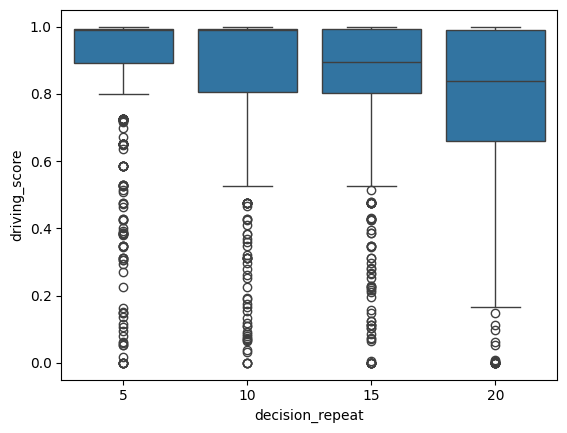

In [8]:
import seaborn as sns


sns.boxplot(df, x="decision_repeat", y="driving_score")
# sns.boxplot(df, x="decision_repeat", y="scenario_time")
# sns.boxplot(df, x="decision_repeat", y="total_time")

In [9]:
oracle = df.xs(5, level="decision_repeat")["driving_score"]
df["driving_score_error"] = (df["driving_score"] - oracle).abs()

agg = df.select_dtypes("number").groupby(by="decision_repeat").mean()
agg

,start_ts,initialized_ts,scenario_done_ts,init_time,scenario_time,total_time,max_steps,route_completion,in_road_percentage,n_crashes,driving_score,driving_score_error
decision_repeat,,,,,,,,,,,,
5,19913.129388,19913.416622,19917.532894,0.287235,4.116272,4.403506,2766.970149,0.966130,0.999987,3.868657,0.878280,0.000000
10,19918.178689,19918.466612,19921.088339,0.287923,2.621727,2.909650,1383.474627,0.967535,0.999985,2.132836,0.864141,0.122095
15,19921.740082,19922.027524,19924.265424,0.287442,2.237900,2.525341,922.316418,0.961224,0.999894,3.013433,0.833762,0.163659
20,19917.194963,19917.481492,19919.563104,0.286529,2.081611,2.368141,691.890882,0.963043,0.999787,3.654709,0.786348,0.201649


<Axes: xlabel='decision_repeat', ylabel='driving_score_error'>

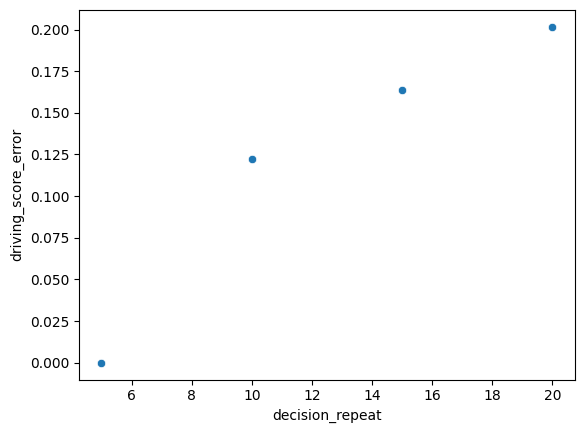

In [10]:
sns.scatterplot(agg, x="decision_repeat", y="driving_score_error")

(0.0, 4.519601046859548)

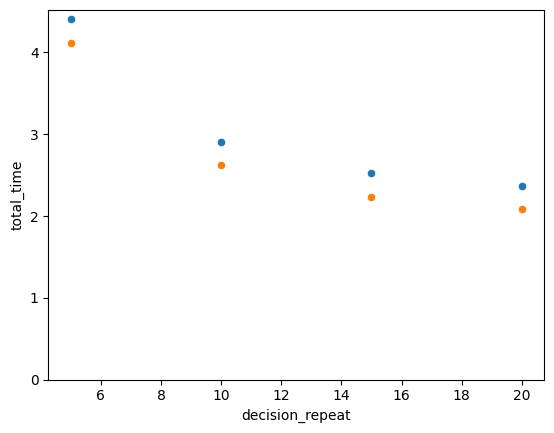

In [14]:
sns.scatterplot(agg, x="decision_repeat", y="total_time")
ax = sns.scatterplot(agg, x="decision_repeat", y="scenario_time")
ax.set_ylim(0)